<a href="https://colab.research.google.com/github/HemantTiwariGitHub/RLCabs/blob/main/DQN_Agent_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cab-Driver Agent

In [6]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time 

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [7]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
   
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([1,2,1])).reshape(1, self.state_size)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        #print(state)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            randAction = random.choice(possible_actions_index)
            return randAction
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            encodedState = env.state_encod_arch1(state)
            batchEncodedState = np.array(encodedState).reshape(1, 36)
            q_value = self.model.predict(batchEncodedState)
            possibleValues = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(possibleValues)]

          
         
   

    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
      self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)

            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)

    def save_tracking_states(self):
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][5])

    def savePickle(self, name):
        with open(name, 'wb') as file:  
          pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [10]:
episodeTime = 24*30 
Episodes = 1000

env = CabDriver()
action_space, state_space, state = env.reset()

state_size = 36
action_size = len(action_space)


agent = DQNAgent(state_size=state_size,action_size=action_size)


rewards_per_episode, episodes = [], []

### DQN block

In [11]:
startTime = time.time()
scoreTracked = []
#### simulation starts ####
for episode in range(Episodes):

    done = False
    score = 0

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    
    currentEpisodeTime=0
    maxEpisodeTime = episodeTime 
   


    while not done:
        # get action for the current state and take a step in the environment
        possible_actions_index, actions = env.requests(state)
      
        #print(state)
        #print(actions)
        #print(possible_actions_index)
        

        action = agent.get_action(state, possible_actions_index, actions)

        #print(action)


        next_state, reward, timePassed = env.next_state_func(state, env.action_space[action], Time_matrix)
        currentEpisodeTime = currentEpisodeTime + timePassed

        if (currentEpisodeTime > maxEpisodeTime):
          done = True
  
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
      

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward

 
        #print(i,": " , state , " :  " , action , " :  " , reward , " : " , next_state , " : " , done, " : " , score)

        state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
          agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-0.0005 * episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    
    if (((episode +1) % 10) == 0):
       agent.save_tracking_states()
    
    if (((episode +1 )% 500) == 0):
      agent.save(name="model_weights.h5")

#### simulation complete ####
        

episode 0, reward -129, memory_length 160, epsilon 1.0
episode 1, reward 116, memory_length 292, epsilon 0.9995051237293776
episode 2, reward -344, memory_length 425, epsilon 0.9990104948350412
episode 3, reward -205, memory_length 571, epsilon 0.9985161131933338
episode 4, reward -150, memory_length 713, epsilon 0.9980219786806598
episode 5, reward -448, memory_length 856, epsilon 0.9975280911734855
episode 6, reward -138, memory_length 997, epsilon 0.9970344505483393
episode 7, reward -160, memory_length 1135, epsilon 0.9965410566818107
episode 8, reward -331, memory_length 1285, epsilon 0.9960479094505515
episode 9, reward -194, memory_length 1433, epsilon 0.9955550087312749
episode 10, reward -177, memory_length 1568, epsilon 0.9950623544007555
episode 11, reward -61, memory_length 1721, epsilon 0.9945699463358298
episode 12, reward 22, memory_length 1846, epsilon 0.9940777844133959
episode 13, reward -65, memory_length 1984, epsilon 0.9935858685104132
episode 14, reward -287, memo

KeyboardInterrupt: ignored

In [12]:
## save stuff as pickle
import os
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

In [13]:
# save rewards_per_episode
save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")

### Tracking Convergence

Average reward of last 100 episodes is 41.88


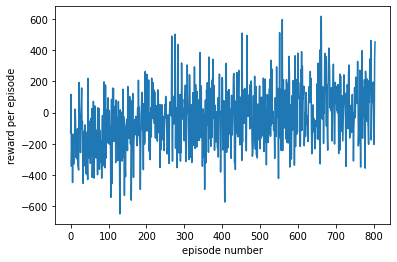

In [14]:

# plot results
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

# save plots in saved_plots/ directory
plt.savefig('rewards.png')

print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-100:]))) 

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()